#TASK1
Prepare Depth Estimation dataset, prepare also plot function that shows inputs and targets in pairs. Note that target data is stored in numpy format because the depth information is in mm. The maximum range of the data is 10000, so we normalize the original data by dividing it by 10000. You need to define such a custom transform. Search how to do that and implement it in your dataset.

NYU dataset
https://drive.google.com/file/d/1LoAaHshy-TwMckp755hi7O2FwsWL2SKU/view?usp=share_link

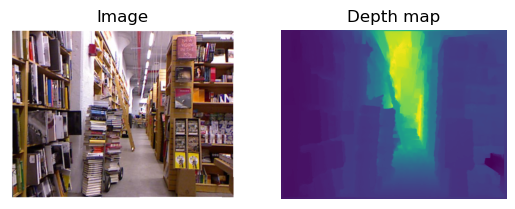

done


In [27]:
import os
import pandas as pd
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class NYUDepthTransform(object):
    
    def __init__(self, denominator=10000):
        self.denom = denominator
        
    def __call__(self, depth_map):
        return np.asarray(depth_map) / self.denom
    

class NYUDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform if transform is not None else self._default_transform()
        self.target_transform = target_transform if target_transform is not None else NYUDepthTransform()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        mask_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        return image, mask
    
    def _default_transform(self):
        return transforms.Compose([
            transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        

def visualize_depth_map(img_pair):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.asarray(img_pair[0].permute(1, 2, 0) ))
    ax1.set_title('Image')
    ax1.set_axis_off()
    ax2.imshow(np.asarray(img_pair[1]))
    ax2.set_title('Depth map')
    ax2.set_axis_off()
    
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    visual_mask_fn = lambda x: np.array(x) / 10000
    data = NYUDataset('./nyu_samples/nyu2_test.csv', './nyu_samples/nyu2_test', target_transform=visual_mask_fn)
    data_custom_transform = NYUDataset('./nyu_samples/nyu2_test.csv', './nyu_samples/nyu2_test')
    assert np.all(data[0][1] == data_custom_transform[0][1])  # check transform
    visualize_depth_map(data[39])

    plt.show()
    print('done')

Here you can find reference of the EfficientDet architecture.

https://github.com/tristandb/EfficientDet-PyTorch

In [28]:
import torch.nn as nn
import torch
import math

class BiFPN(nn.Module):
    def __init__(self,  fpn_sizes):
        super(BiFPN, self).__init__()
        
        P3_channels, P4_channels, P5_channels, P6_channels, P7_channels = fpn_sizes
        self.W_bifpn = 64

        #self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_td_conv_2  = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_act   = nn.ReLU()
        self.p6_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p5_td_conv  = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_td_conv_2  = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p5_td_act   = nn.ReLU()
        self.p5_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p4_td_conv  = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_td_conv_2  = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p4_td_act   = nn.ReLU()
        self.p4_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_upsample   = nn.Upsample(scale_factor=2, mode='nearest')


        self.p3_out_conv = nn.Conv2d(P3_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p3_out_conv_2 = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p3_out_act   = nn.ReLU()
        self.p3_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p3_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_upsample  = nn.Upsample(scale_factor=2, mode='nearest')

        #self.p4_out_conv = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_out_conv = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p4_out_act   = nn.ReLU()
        self.p4_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_downsample= nn.MaxPool2d(kernel_size=2)

        #self.p5_out_conv = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_out_conv = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p5_out_act   = nn.ReLU()
        self.p5_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_downsample= nn.MaxPool2d(kernel_size=2)

        #self.p6_out_conv = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_out_conv = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_out_act   = nn.ReLU()
        self.p6_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        #self.p4_downsample= nn.MaxPool2d(kernel_size=2)


        self.p7_out_conv = nn.Conv2d(P7_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p7_out_conv_2 = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p7_out_act  = nn.ReLU()
        self.p7_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p7_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p7_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)


    def forward(self, inputs):
        epsilon = 0.0001
        P3, P4, P5, P6, P7 = inputs
        #print ("Input::", P3.shape, P4.shape, P5.shape, P6.shape, P7.shape)
        #P6_td = self.p6_td_conv((self.p6_td_w1 * P6 ) /
        #                         (self.p6_td_w1 + epsilon))

        P7_td  = self.p7_out_conv(P7)

        P6_td_inp = self.p6_td_conv(P6)
        P6_td = self.p6_td_conv_2((self.p6_td_w1 * P6_td_inp + self.p6_td_w2 * P7_td) /
                                 (self.p6_td_w1 + self.p6_td_w2 + epsilon))
        #P6_td = self.p6_td_conv_2(P6_td_inp)
        P6_td = self.p6_td_act(P6_td)
        P6_td = self.p6_td_conv_bn(P6_td)

         
        P5_td_inp = self.p5_td_conv(P5)
        #print (P5_td_inp.shape, P6_td.shape)
        P5_td = self.p5_td_conv_2((self.p5_td_w1 * P5_td_inp + self.p5_td_w2 * P6_td) /
                                 (self.p5_td_w1 + self.p5_td_w2 + epsilon))
        P5_td = self.p5_td_act(P5_td)
        P5_td = self.p5_td_conv_bn(P5_td)

        #print (P4.shape, P5_td.shape)
        P4_td_inp = self.p4_td_conv(P4)
        P4_td = self.p4_td_conv_2((self.p4_td_w1 * P4_td_inp + self.p4_td_w2 * self.p5_upsample(P5_td)) /
                                 (self.p4_td_w1 + self.p4_td_w2 + epsilon))
        P4_td = self.p4_td_act(P4_td)
        P4_td = self.p4_td_conv_bn(P4_td)


        P3_td  = self.p3_out_conv(P3)
        P3_out = self.p3_out_conv_2((self.p3_out_w1 * P3_td + self.p3_out_w2 * self.p4_upsample(P4_td)) /
                                 (self.p3_out_w1 + self.p3_out_w2 + epsilon))
        P3_out = self.p3_out_act(P3_out)
        P3_out = self.p3_out_conv_bn(P3_out)

        #print (P4_td.shape, P3_out.shape)

        P4_out = self.p4_out_conv((self.p4_out_w1 * P4_td_inp  + self.p4_out_w2 * P4_td + self.p4_out_w3 * self.p3_downsample(P3_out) )
                                    / (self.p4_out_w1 + self.p4_out_w2 + self.p4_out_w3 + epsilon))
        P4_out = self.p4_out_act(P4_out)
        P4_out = self.p4_out_conv_bn(P4_out)

        
        P5_out = self.p5_out_conv(( self.p5_out_w1 * P5_td_inp + self.p5_out_w2 * P5_td + self.p5_out_w3 * self.p4_downsample(P4_out) )
                                    / (self.p5_out_w2 + self.p5_out_w3 + epsilon))
        P5_out = self.p5_out_act(P5_out)
        P5_out = self.p5_out_conv_bn(P5_out)

        
        P6_out = self.p6_out_conv((self.p6_out_w1 * P6_td_inp + self.p6_out_w2 * P6_td + self.p6_out_w3 * (P5_out) )
                                    / (self.p6_out_w1 + self.p6_out_w2 + self.p6_out_w3 + epsilon))
        P6_out = self.p6_out_act(P6_out)
        P6_out = self.p6_out_conv_bn(P6_out)


        P7_out = self.p7_out_conv_2((self.p7_out_w1 * P7_td + self.p7_out_w2 * P6_out) /
                                 (self.p7_out_w1 + self.p7_out_w2 + epsilon))
        P7_out = self.p7_out_act(P7_out)
        P7_out = self.p7_out_conv_bn(P7_out)
        

        return [P3_out, P4_out, P5_out, P6_out, P7_out]

In [91]:
fpn = BiFPN([40, 112, 192, 192, 1280])

c1 = torch.randn([1, 40, 64, 64])
c2 = torch.randn([1, 112, 32, 32])
c3 = torch.randn([1, 192, 16, 16])
c4 = torch.randn([1, 192, 16, 16])
c5 = torch.randn([1, 1280, 16, 16])

In [92]:
print(c1.shape, c2.shape, c3.shape, c4.shape, c5.shape)
c1,c2,c3,c4,c5=fpn([c1,c2,c3,c4,c5])
fpn2 = BiFPN([64, 64, 64, 64, 64])
print(c1.shape, c2.shape, c3.shape, c4.shape, c5.shape)
c1,c2,c3,c4,c5=fpn2([c1,c2,c3,c4,c5])
print(c1.shape, c2.shape, c3.shape, c4.shape, c5.shape)

torch.Size([1, 40, 64, 64]) torch.Size([1, 112, 32, 32]) torch.Size([1, 192, 16, 16]) torch.Size([1, 192, 16, 16]) torch.Size([1, 1280, 16, 16])
torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 16, 16]) torch.Size([1, 64, 16, 16]) torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 64, 64]) torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 16, 16]) torch.Size([1, 64, 16, 16]) torch.Size([1, 64, 16, 16])


Above is an illustration how to use BiFPN node. But note that BiFPN can be stacked in order to process multi-resolution information.

#TASK2 
Below you can find an example how to use a pretrained resnet18 as backbone. Now use this backbone feature outputs, connect them to 5 BiFPN blocks. Write everything in class ResnetBiFPN(). Then create class EfficientBiFPN using efficientb0 example shown at last.

In [31]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)

/home/bartlomiej/anaconda3/envs/p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/bartlomiej/anaconda3/envs/p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.layer1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer2 = resnet.layer1
        self.layer3 = resnet.layer2
        self.layer4 = resnet.layer3
        self.layer5 = resnet.layer4
    def get_features(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1,x2,x3,x4,x5

In [83]:
resnet_encoder = ResNet()

In [93]:
x1,x2,x3,x4,x5 = resnet_encoder.get_features(data[0][0].unsqueeze(0))
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

torch.Size([1, 64, 120, 160]) torch.Size([1, 64, 120, 160]) torch.Size([1, 128, 60, 80]) torch.Size([1, 256, 30, 40]) torch.Size([1, 512, 15, 20])


In [94]:
fpn = BiFPN([64, 64, 128, 256, 512])
x1,x2,x3,x4,x5=fpn([x1,x2,x3,x4,x5])
# this cant be done with the ResNet class provided.

torch.Size([1, 64, 120, 160]) torch.Size([1, 64, 120, 160]) torch.Size([1, 128, 60, 80]) torch.Size([1, 256, 30, 40]) torch.Size([1, 512, 15, 20])


RuntimeError: The size of tensor a (40) must match the size of tensor b (20) at non-singleton dimension 3

In [76]:
# if that could be done the class would look like this
class ResnetBiFPN(nn.Module):
    def __init__(self):
        super(ResnetBiFPN, self).__init__()
        self.backbone = ResNet()
        blocks = [BiFPN([64, 64, 64, 64, 64]) for _ in range(4)]
        blocks.insert(0, BiFPN([64, 64, 128, 256, 512]))
        self.bifpn_blocks = nn.Sequential(*blocks)

    def forward(self, input):
        x1, x2, x3, x4, x5 = self.backbone.get_features(input)
        return self.bifpn_blocks([x1, x2, x3, x4, x5])

In [40]:
import torchvision
encoder = torchvision.models.efficientnet_b0()

In [81]:
x = data[0][0].unsqueeze(0)
for i, l in enumerate(encoder.features):
    x = l(x)
    print(i, len(l), x.shape)
# selecting 5 blocks to extract features from, for the sake of compatibility with the BiFPN class
# (3, 5, 6, 7, 8) is the only combination that could run

0 3 torch.Size([1, 32, 240, 320])
1 1 torch.Size([1, 16, 240, 320])
2 2 torch.Size([1, 24, 120, 160])
3 2 torch.Size([1, 40, 60, 80])
4 3 torch.Size([1, 80, 30, 40])
5 3 torch.Size([1, 112, 30, 40])
6 4 torch.Size([1, 192, 15, 20])
7 1 torch.Size([1, 320, 15, 20])
8 3 torch.Size([1, 1280, 15, 20])


In [69]:
class EfficientNetFeatures(nn.Module):
    def __init__(self):
        super(EfficientNetFeatures, self).__init__()
        self.net = models.efficientnet_b0(pretrained=True)
        self.extract_ids = [3, 5, 6, 7, 8]

    def get_features(self, x):
        features = []
        for i, l in enumerate(self.net.features):
            x = l(x)
            if i in self.extract_ids:
                features.append(x)
        return features

In [95]:
effnet_encoder = EfficientNetFeatures()
x1,x2,x3,x4,x5 = effnet_encoder.get_features(data[0][0].unsqueeze(0))
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
fpn = BiFPN([40, 112, 192, 320, 1280])
x1,x2,x3,x4,x5=fpn([x1,x2,x3,x4,x5])
fpn2 = BiFPN([64, 64, 64, 64, 64])
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
x1,x2,x3,x4,x5=fpn2([x1,x2,x3,x4,x5])
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

torch.Size([1, 40, 60, 80]) torch.Size([1, 112, 30, 40]) torch.Size([1, 192, 15, 20]) torch.Size([1, 320, 15, 20]) torch.Size([1, 1280, 15, 20])
torch.Size([1, 64, 60, 80]) torch.Size([1, 64, 30, 40]) torch.Size([1, 64, 15, 20]) torch.Size([1, 64, 15, 20]) torch.Size([1, 64, 15, 20])
torch.Size([1, 64, 60, 80]) torch.Size([1, 64, 30, 40]) torch.Size([1, 64, 15, 20]) torch.Size([1, 64, 15, 20]) torch.Size([1, 64, 15, 20])


In [96]:
class EfficientBiFPN(nn.Module):
    def __init__(self):
        super(EfficientBiFPN, self).__init__()
        self.backbone = EfficientNetFeatures()
        blocks = [BiFPN([64, 64, 64, 64, 64]) for _ in range(4)]
        blocks.insert(0, BiFPN([40, 112, 192, 320, 1280]))
        self.bifpn_blocks = nn.Sequential(*blocks)

    def forward(self, input):
        x1, x2, x3, x4, x5 = self.backbone.get_features(input)
        return self.bifpn_blocks([x1, x2, x3, x4, x5])

In [97]:
effnet_fpn = EfficientBiFPN()
x1,x2,x3,x4,x5 = effnet_fpn(data[0][0].unsqueeze(0))
print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)

torch.Size([1, 64, 60, 80]) torch.Size([1, 64, 30, 40]) torch.Size([1, 64, 15, 20]) torch.Size([1, 64, 15, 20]) torch.Size([1, 64, 15, 20])
